In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D Trap example
Hucul-west blade trap.

In [1]:
import sys
import logging, os
from time import time
import numpy as np
# Importing pyface.qt is for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# which is incompatible with "pyside" in package "mayavi". Python 2.
# import pyface.qt
import matplotlib.pyplot as plt
from multiprocessing import Pool

sys.path.append('../../')   # add path of package "bem" to search list.
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list.

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

### Import STL geometry file

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "Hucul-west_20180813_0d1-0d1-5"
suffix = ""

At first coding number of electrode colors are unknown, users need to specify an arbitrary rename argument as a first attempt, then `stl.stl_to_mesh()` will drop unnamed coding numbers below for next formal rename.

In [3]:
# scale to natural units (ion height)
scale = 200e-6    # Distance from ion to electrode is 40 um.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    # s_nta is intermediate processed stl file.
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    print("Import stl:",os.path.abspath("./"+prefix+".stl"),"\n")
    print("Electrode colors (numbers):\n")
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,rename={1:"DC1"}))    

Import stl: /home/wwcphy/codes/bem_log/bem/examples/Hucul-west_3DTrap/Hucul-west_20180813_0d1-0d1-5.stl 

Electrode colors (numbers):

dropping 2581
dropping 23887
dropping 1530
dropping 8456
dropping 1882
dropping 28165
dropping 24
dropping 0
dropping 1633
dropping 30653
dropping 30850
dropping 24603
dropping 24063


The formal rename of electrode. Assign each electrode a string name instead of its color coding. Use the numbers you get above.  
`stl.stl_to_mesh()` prints normal vectors (different faces) in each electrode.

You can set `quiet=True` to mute the printout of planes and normals from `stl_to_mesh()` function.

In [4]:
print(len(s_nta), type(s_nta),"\n")
# s_nta is a length 3 tuple. (normal, triangle, attribute) 
# Normal direction of each triangle, three vetice of triangles, coding number of colors.
print("Triangles:",len(s_nta[0]),"\nColors:",len(s_nta[2]),"\n")    # This isn't right.

# stl_to_mesh() only assigns names and does scaling, doing no triangulation to stl mesh.
# "scale=scale/1e-6" only scales dimensionless scale/1e-6.    1e-6: if stl uses micron as unit. 
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,
    rename={0:"DC1",30653:"DC2",30850:"DC3",24603:"DC4",1633:"DC5", 
            1530:"DC6",28165:"DC7",1882:"DC8",8456:"DC9",23887:"DC10",
           24:"RF1",24063:"RF2"}, quiet=False))    
    # 0:Black, 24:Red, 24311:Default, 1633:Dark Green, 30653:White, 28165:Cyran, 1882:Yellow, 1530:Orange
    # 30850:blue wall, 24063:pink, 830/2581:default gold, 24603:meganta, 23887:violet,8456:Dark Gray

3 <class 'tuple'> 

Triangles: 2672 
Colors: 2672 

dropping 2581
7 planes in electrode DC10
normals vectors:
 [[-8.47737149e-16 -4.99983281e-01 -8.66035044e-01]
 [ 2.06010476e-01 -8.47458422e-01  4.89258528e-01]
 [ 3.07936207e-16 -6.77893817e-01 -7.35159814e-01]
 [-4.45956945e-01  7.75148511e-01 -4.47512239e-01]
 [ 2.72330177e-15 -8.66035044e-01  4.99983281e-01]
 [ 9.84981262e-16  2.97683328e-01  9.54664648e-01]
 [-1.94896008e-16  4.99983281e-01  8.66035044e-01]]
7 planes in electrode DC6
normals vectors:
 [[ 4.83951427e-16  4.99983281e-01  8.66035044e-01]
 [ 4.45956945e-01  7.75148511e-01 -4.47512239e-01]
 [-4.17889978e-16 -6.77893817e-01 -7.35159814e-01]
 [-2.06010476e-01 -8.47458422e-01  4.89258528e-01]
 [ 2.84207585e-16 -8.66035044e-01  4.99983281e-01]
 [ 3.67308108e-16  2.97683328e-01  9.54664648e-01]
 [ 1.46171999e-16 -4.99983281e-01 -8.66035044e-01]]
7 planes in electrode DC9
normals vectors:
 [[ 4.45956945e-01 -7.75148511e-01  4.47512239e-01]
 [-1.99531912e-16 -6.77893817e-01 

### Generate triangle mesh with constraints

The meshes are 2-dimensional triangles on the surface of electrodes. The region enclosed by constraint shape can have finer mesh. Triangulation is done by `triangle` C library.

Output vtk: /home/wwcphy/codes/bem_log/bem/examples/Hucul-west_3DTrap/Hucul-west_20180813_0d1-0d1-5.vtk


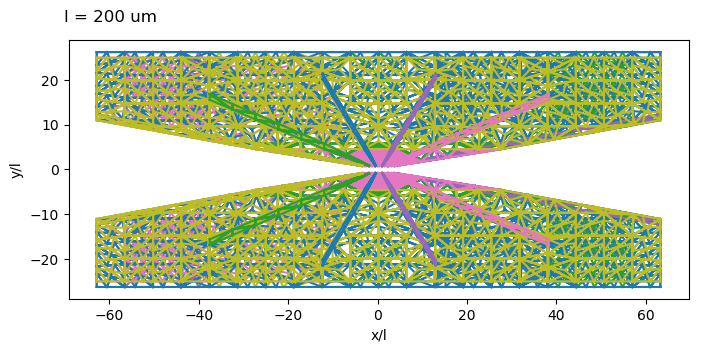

In [5]:
# set .1 max area within 3
# areas_from_constraints specifies sphere with finer mesh inside it.
mesh.areas_from_constraints(Sphere(center=np.array([0., 0., 0.]),
           radius=5, inside=0.2, outside=8))    # "inside", "outside" set different mesh densities.
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix+suffix)
print("Output vtk:",os.path.abspath("./"+prefix+suffix+".vtk"))    # output path

# Plot triangle meshes.
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(8,6), dpi=100)
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
ax.text(-70,33,"l = %d um"%(scale/1e-6),fontsize=12)
mesh.plot(ax)

### Main boundary element calculations

In `run_job` function, `job` is `Configuration` instance and `grid` is discretirized spatial grid (not the mesh). The general workflow (also the routine of BEM method) are:  
1. `solve_singularities()` solves charge distributions by iterative methods to make it consistent with one electrode at 1V and others at 0V (unit potentials). `adapt_mesh()` refines meshes adaptively to achieve certain precision while solving sigulartities.
2. Compute potentials on given grid points by `simulate()`, based on the charge distributions gotten previously.
3. Potential data of each unit potential are saved seperately to a `Result` instance, and also export to VTK files.
4. Return total accumulated charge per electrode in the end.

Major calculations calls `fastlap` C library which uses a pre-conditioned, adaptive, multipole-accelerated algorithm for solving Laplace problem. Two parameters control multipole acceleration.
+ numMom, the number of multipole
+ numLev, the number of levels in the hierarchical spatial decomposition.  
num_lev=1 means direct computation without multipole acceleration. See fastlap ug.pdf and README.rst.

In [6]:
# Define calculation function.
def run_job(args):
    # job is Configuration instance.
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min angle 15 deg.
    job.adapt_mesh(triangles=4e2, opts="q15Q")
    job.adapt_mesh(triangles=1e3, opts="q15Q")
    # solve for surface charges
    job.solve_singularities(num_mom=4, num_lev=3)
    # get potentials and fields
    RF_field = (job.name=="RF1") or (job.name=="RF2")
    result = job.simulate(grid, field=RF_field, num_lev=2)    # For "RF", field=True computes the field.
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

Create a grid in unit of scaled length `l`. Only choose the interested region (trap center) to save time.

For reference, to compute Hucul-west trap, grid shape = (40, 40, 40) takes 1233 s.

In [7]:
# grid to evalute potential and fields atCreate a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
n, s = 2*60, 0.05  
Lx, Ly, Lz = 2, 2, 2    # in the unit of scaled length l
sx, sy, sz = s, s, s
# ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
nx, ny, nz = [2*np.ceil(L/2.0/s).astype('int') for L in (Lx, Ly, Lz)]
print("Size/l:", Lx, Ly, Lz)
print("Step/l:", sx, sy, sz)
print("Shape (grid point numbers):", nx, ny, nz)
grid = Grid(center=(0, 0, 0), step=(sx, sy, sz), shape=(nx, ny, nz))
# Grid center (nx, ny ,nz)/2 is shifted to origin
print("Grid origin/l:", grid.get_origin()[0])

Size/l: 2 2 2
Step/l: 0.05 0.05 0.05
Shape (grid point numbers): 40 40 40
Grid origin/l: -0.9750000000000001


Calculation. Parallel computation `Pool().map`

In [12]:
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() picks one electrode each time.
# run the different electrodes on the parallel pool
pmap = Pool().map # parallel map
# pmap = map # serial map
t0 = time()
list(pmap(run_job, ((job, grid, prefix+suffix) for job in jobs)))
print("Computing time: %f s"%(time()-t0))
# run_job casts a word after finishing each electrode.

finished job DC8
finished job DC9
finished job DC7
finished job DC6
finished job DC10
finished job DC1
finished job DC5
finished job DC2
finished job DC3
finished job RF1
finished job DC4
finished job RF2
Computing time: 1232.6977899074554


### Contour plot of potential/pseudo-potential in 3 directions

yz plane, RF1 pseudo
p max 5.60789 
p min 1.50055e-07


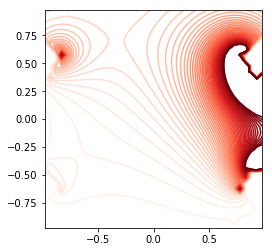

In [8]:
# isocontour plot of RF pseudopotential radially from x (axial) direction
result = Result.from_vtk(prefix+suffix, "RF1")
p = result.pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]//2]    # p.shape[0]/2 is in the middle of x.
p = p[p.shape[0]//2]    # get a slice of yz plane at x = p.shape[0]/2.
print("yz plane, RF1 pseudo")
maxp,minp = np.amax(p),np.amin(p)
print("p max", maxp,"\np min", minp)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp/5, 50), cmap=plt.cm.Reds)

yz plane, DC3 potential
p max 1.00179 
p min -0.00152954


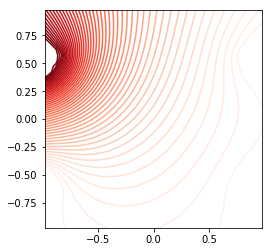

In [9]:
# isocontour plot of DC potential from x (axial) direction
ele = "DC3"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]//2]
p = p[p.shape[0]//2]
print("yz plane, %s potential"%ele)
maxp,minp = np.amax(p),np.amin(p)
print("p max", maxp,"\np min", minp)
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Reds)    # 2e-2

xy plane, DC3 potential
p max 1.01144 
p min -0.00269243


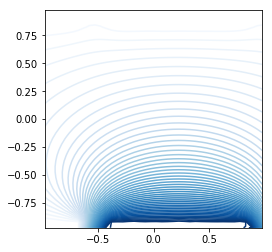

In [10]:
# isocontour plot of electrode potential (electrode profile) from z direction
ele = "DC3"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
offset = 8
x = grid.to_mgrid()[:,:,:,p.shape[2]//2+offset]
p = p[:,:,p.shape[2]//2+offset]
print("xy plane, %s potential"%ele)
maxp,minp = np.amax(p),np.amin(p)
print("p max", maxp,"\np min", minp)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(minp, maxp, 50), cmap=plt.cm.Blues)

xz plane, DC1 potential
p max 0.0145086 
p min 0.000517573


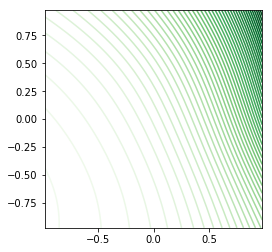

In [11]:
# isocontour plot of single DC potential from y direction
ele = "DC1"
result = Result.from_vtk(prefix+suffix, ele)
p = result.potential
x = grid.to_mgrid()[:,:,p.shape[1]//2]
p = p[:,p.shape[1]//2]
print("xz plane, %s potential"%ele)
maxp,minp = np.amax(p),np.amin(p)
print("p max", maxp,"\np min", minp)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Greens)

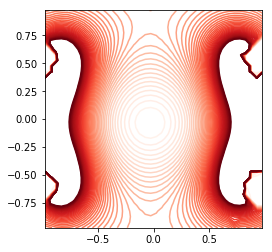

In [12]:
# isocontour plot of total pseudopotential.
# Pay attention, field can be linealy superpositioned but pseudopotential can't.
result1 = Result.from_vtk(prefix+suffix, "RF1")
result2 = Result.from_vtk(prefix+suffix, "RF2")
field = result1.field + result2.field
pp = (field**2).sum(axis=0)
x = grid.to_mgrid()[:, pp.shape[0]//2]
p = pp[pp.shape[0]//2]
maxp,minp = np.amax(p),np.amin(p)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(minp, maxp/10, 50), cmap=plt.cm.Reds)

In [13]:
result = Result.from_vtk(prefix+suffix, "DC1")
p = result.potential
coord = grid.to_mgrid()
print(coord.shape)    # length nx, ny, nz
print(coord[:,p.shape[0]//2].shape)    # plane at nx/2
print(p.shape)

(3, 40, 40, 40)
(3, 40, 40)
(40, 40, 40)


In [14]:
# Verify the symmetry of potential distribution (and then know axes).
print("x axis")
print(p[0,ny//2-1,nz//2-1], p[nx-1,ny//2-1,nz//2-1])
print(p[0+10,ny//2-1,nz//2-1], p[nx-1-10,ny//2-1,nz//2-1])  # x

print("y axis")
print(p[nx//2-1,0,nz//2-1], p[nx//2-1,ny-1,nz//2-1])
print(p[nx//2-1,0+10,nz//2-1], p[nx//2-1,ny-1-10,nz//2-1])  # y

print("z axis")
print(p[nx//2-1,ny//2-1,0], p[nx//2-1,ny//2-1,nz-1])
print(p[nx//2-1,ny//2-1,0+5], p[nx//2-1,ny//2-1,nz-1-5])  # z

x axis
0.000799286 0.00940817
0.00136184 0.004571
y axis
0.000664024 0.000488506
0.00184822 0.00164376
z axis
0.00148954 0.00488532
0.00160281 0.00398886


### 3D plot of mesh and potential isocontour
By mayavi GUI (seems to have problem now.)

In [15]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Can't lauch GUI through X11 remote and caused dead kernel.

## Data processing
Using `electrode` package. (`GridElectrode.from_result()` method has problems for now, use `from_vtk()` directly.)  
I perfer to split data processing part to a new notebook. See `DataProcessing_SE.ipynb`.

In [16]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 RF1 RF2".split():
    r = Result.from_vtk(prefix+suffix, name)
    e = GridElectrode.from_result(r,maxderiv=4)
#     e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)
    e.name = name
    s.append(e)

In [17]:
import scipy.constants as ct
l = 200e-6 # length scale
u = 168 # peak rf voltage
o = 34.1e6*2*np.pi # rf frequency
m = 174*ct.atomic_mass # ion mass
q = 1*ct.elementary_charge # ion charge
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.
rf_scale = s.rf_scale(m,q,l,o)

# Set voltages (from brittonlab experiments)
V0 = u
V1,V2 = 5,5
DCvol = {"DC1":V1,"DC2":V2,"DC3":0,"DC4":V2,"DC5":V1,
         "DC6":V1,"DC7":V2,"DC8":0,"DC9":V2,"DC10":V1}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
s["RF1"].rf, s["RF2"].rf = V0, V0    # s["RF"] == e, create attribute e.rf
print("RF1",s["RF1"].rf,"V\nRF2",s["RF2"].rf,"V")

DC1 5 V
DC2 5 V
DC3 0 V
DC4 5 V
DC5 5 V
DC6 5 V
DC7 5 V
DC8 0 V
DC9 5 V
DC10 5 V
RF1 168 V
RF2 168 V


In [18]:
xi = (0., 0., 0.)
x0 = s.minimum(xi, method='Nelder-Mead')
# x0 = np.array([0.2,0.0,0.0])
print("minimum x0:",x0)
print("minimum offset: {}\n".format(x0-xi))
for line in s.analyze_static(x0, m=m, q=q, l=l, o=o, min_off=True):
    print(line)

/home/wwcphy/Programs/anaconda3/envs/ele36/lib/python3.6/site-packages/scipy/optimize/_minimize.py:501: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/wwcphy/Programs/anaconda3/envs/ele36/lib/python3.6/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


minimum x0: [ 0.2250002  -0.01347141 -0.03146173]
minimum offset: [ 0.2250002  -0.01347141 -0.03146173]

parameters:
 f=34.1 MHz, m=174 amu, q=1 qe, l=200 µm, scale=0.00869 V'/V_SI
corrdinates:
 analyze point: [ 0.2250002  -0.01347141 -0.03146173]
               ([45.00004084 -2.69428203 -6.2923454 ] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0.86 eV
 rf pseudo: 0.00043 eV
 saddle not found
force:
 dc electrical: [-0.00190306 -0.02699057 -0.00683843] eV/l
               ([  -9.51532005 -134.95284421  -34.1921408 ] eV/m)
 rf pseudo: [-9.94883104e-06  4.71694742e-02  3.69908628e-03] eV/l
           ([-4.97441552e-02  2.35847371e+02  1.84954314e+01] eV/m)
modes:
 pp+dc normal curvatures: [1.01919071 1.63969654 2.53564923]
 motion is bounded: False
 pseudopotential modes:
  a: 0.5982 MHz, [-9.18958583e-04 -9.67411148e-01 -2.53209058e-01]
  b: 0.7588 MHz, [-9.99999173e-01  1.11678776e-03 -6.37556603e-04]
  c: 0.9436 MHz, [ 8.995601

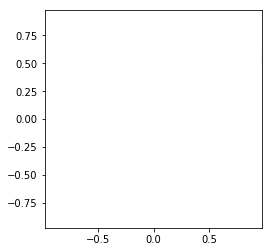

In [19]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)